__<h2>Importent Setup and library:</h2>__

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pathlib
data_dir = "/content/drive/MyDrive/MLProjects/dataset/chest_xray"
data_dir_train = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/Train"
data_dir_validation = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/Test"

Data cleaning

In [5]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/MLProjects/dataset/chest_xray/"
image_extensions = [".png", ".svg", ".gif", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/tmp/ipython-input-328247563.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
img_height,img_width=180, 180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


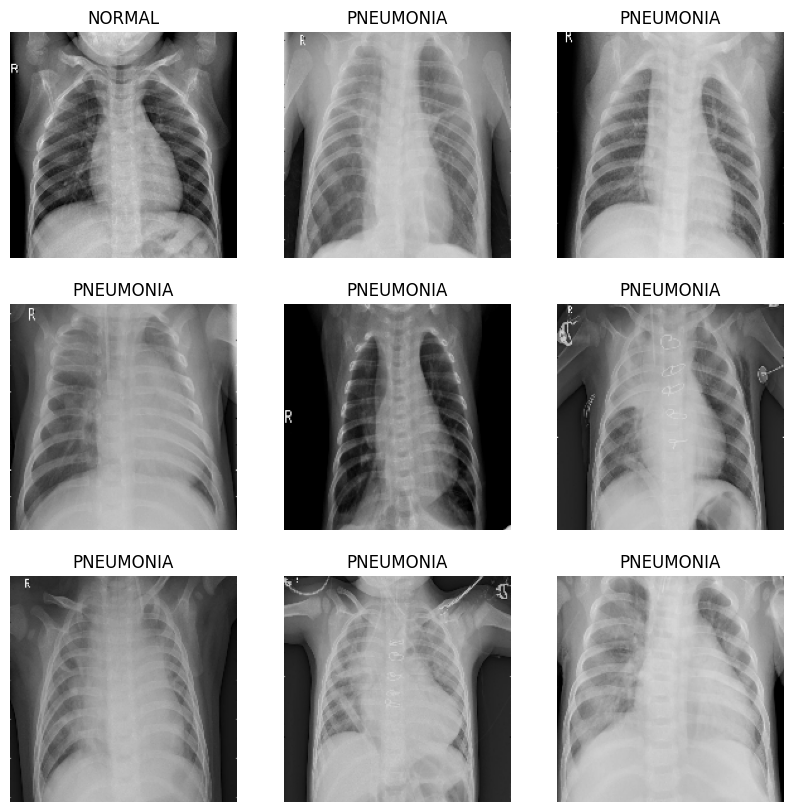

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
!pip install tensorflow


In [11]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


163/163 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - accuracy: 0.8549 - loss: 0.4474 - val_accuracy: 0.7452 - val_loss: 0.7674
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.9611 - loss: 0.1019 - val_accuracy: 0.7388 - val_loss: 0.9458
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.9753 - loss: 0.0673 - val_accuracy: 0.7276 - val_loss: 1.1440


In [14]:
activation=2
model = model((180,180,3),activation)
keras.utils.plot_model(model, show_shapes=True)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 180 (of type <class 'int'>)

In [15]:
tf.keras.models.save_model(model,'xray_model.hdf5')

In [16]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.9 MB/s eta 0:00:00


In [17]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (180,180)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Writing app.py
